In [1]:
from astropy import stats
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle

import aplpy
import mpdaf.obj 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
from mpl_toolkits import mplot3d
from matplotlib.patches import Rectangle

import sys 
from importlib import reload  

from scipy.stats import norm  

In [2]:
sys.path.append('../') 
import FRB_external_functions as frb

In [3]:
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
save_plots = False

### Host Galaxy

In [5]:
# Load in image: HOST GALAXY

hdul_hg = fits.open('HG_191001_FORS2_I_ac.fits')
hdr_hg = hdul_hg[0].header
data_hg = hdul_hg[0].data

ncol = hdr_hg['NAXIS1']         #Number of columns
nrow = hdr_hg['NAXIS2']         #Number of rows

xm_ra = hdr_hg['CRVAL1']        # RA mid
xd_ra = hdr_hg['CDELT1']        # RA per. pixel 
xi_ra = xm_ra - xd_ra*ncol      # RA start
xf_ra = xm_ra + xd_ra*ncol      # RA end

xm_dec = hdr_hg['CRVAL2']       # dec mid
xd_dec = hdr_hg['CDELT2']       # dec per. pixel 
xi_dec = xm_dec - xd_dec*nrow   # dec start
xf_dec = xm_dec + xd_dec*nrow   # dec end

x0_ra = hdr_hg['CRPIX1']        # Reference pixel 
x0_dec = hdr_hg['CRPIX2']       # Reference pixel 

k_dec = 0.25239618              # dec; arcsec per. pixel
k_ra = 0.01680575*15            # RA; arcsec per. pixel  (1s = 15'')

### Plotting the position of the FRB 

In [6]:
reload(frb);

**Uncertainties in FRB position**

In [7]:
# Uncertainties
a_stat, a_sys = 0.13, 0.11
b_stat, b_sys = 0.08, 0.10
PA = 90

# Uncertainties [arcsec]
a_sig = frb.unc(a_stat, a_sys)
b_sig = frb.unc(b_stat, b_sys)

# Uncertainties [pixels]
a_pix = a_sig/k_ra              
b_pix = b_sig/k_dec
print(a_sig, b_sig)

0.17029386365926402 0.12806248474865697


**Calculating the difference in pixels from the center of the image to the location of the FRB**

In [8]:
dec_image = '-54d44m53.855s' # centrum of image (dec)
dec_frb = '-54d44m51.9s'     # FRB position (dec)

dec_image = mpdaf.obj.sexa2deg([dec_image, 0])[0]   
dec_frb = mpdaf.obj.sexa2deg([dec_frb, 0])[0]

dec_delta = dec_image-dec_frb
pix_delta = dec_delta/xd_dec

**Calculating the difference in pixels from the center of the image to the location of the HG**

In [9]:
hg_pos = SkyCoord('21h33m24.4648s -54d44m54.862s', frame='icrs')

dec_image = '-54d44m53.855s' # billede centrum (dec)
dec_hg = '-54d44m54.862s'     # hg pos (dec)

dec_image = mpdaf.obj.sexa2deg([dec_image, 0])[0]   
dec_hg = mpdaf.obj.sexa2deg([dec_hg, 0])[0]

dec_delta_hg = dec_image-dec_hg
dec_pix_delta_hg = dec_delta_hg/xd_dec

ra_image = '21h33m24.37s' # billede centrum (ra)
ra_hg = '21h33m24.4648s'     # hg pos (ra)

ra_image = mpdaf.obj.sexa2deg([0, ra_image])[1]   
ra_hg = mpdaf.obj.sexa2deg([0, ra_hg])[1]

ra_delta_hg = ra_image-ra_hg
ra_pix_delta_hg = ra_delta_hg/xd_ra

# DS9
dec_pix_delta_hg = 4.55
ra_pix_delta_hg = 3.65

**Plotting image of sky area and host galaxy**

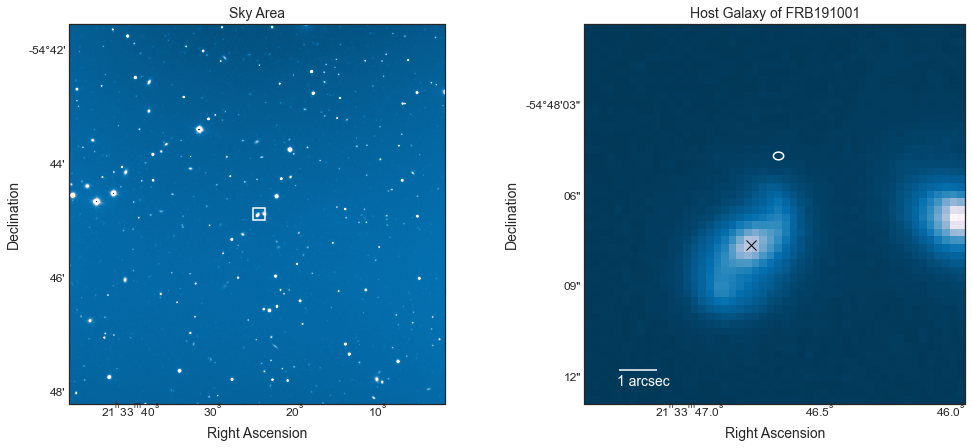

In [10]:
position = SkyCoord('21h33m24.37 -54d44m53.855s', frame='icrs') 
wcs = WCS(hdr_hg)
size=(50,50) #ny, nx
cutout = Cutout2D(data_hg, position, size, wcs=wcs)

x0, y0 = 25, 25-pix_delta
a, b =   b_pix, a_pix
theta = Angle(PA, 'deg')

fig, (ax1, ax2) = plt.subplots(figsize=(17,7),ncols=2, subplot_kw={'projection': wcs})

#ax1 = fig.add_subplot(121)
ax1.imshow(data_hg, cmap='PuBu_r', vmin=1.052e02, vmax=1.328e02)
cutout.plot_on_original(color='white', ax=ax1, lw=1.5)
ax1.set_title('Sky Area', fontsize=14)
ax1.set_xlabel('Right Ascension', fontsize=14)
ax1.set_ylabel('Declination', fontsize=14)

#ax2 = fig.add_subplot(122)
ax2.imshow(cutout.data, cmap='PuBu_r', vmin=cutout.data.min(), vmax=cutout.data.max())  # origin='lower' 
ax2.set_title('Host Galaxy of FRB191001', fontsize=14)
ax2.set_xlabel('Right Ascension', fontsize=14)
ax2.set_ylabel('Declination', fontsize=14)

e = mpatches.Ellipse((x0, y0), 2*a, 2*b,  theta.degree, edgecolor='white', facecolor='none', lw=1.5) 
ax2.add_patch(e)

#ax2.text(3.8,5, f'{round(frb.arc2kpc(1, z),1)}kpc', color='white', fontsize=14)
ax2.hlines(4,5+1/k_ra,4, color='white')
ax2.text(3.8,1.9, '1 arcsec', color='white', fontsize=14)

ax2.plot(25-ra_pix_delta_hg,25-dec_pix_delta_hg,'x',color='black', ms=10)

if save_plots:
        fig.savefig('hostgalaxy.pdf', dpi=300);

White ellipse marks the $1 \sigma$ uncertainty in the position of the FRB.

### Spectrum of HG

In [11]:
## Load in spectrum: FRB
hdul_frb = fits.open('FRB191001_GMOSspec.fits')
hdr_frb = hdul_frb[0].header
data_frb = hdul_frb[1].data
wl = data_frb['WAVELENGTH'] # in units AA
flux = data_frb['FLUX']     # in units of x10^-17 erg/s/cm^2/Å
sig = data_frb['ERROR']     # in units of x10^-17 erg/s/cm^2/Å 

**Signal to noise ratio S/N**

In [12]:
S_N = flux[1989]/sig[1989]
print('At wl =', wl[1989],'S/N =', S_N)

At wl = 8001.229 S/N = 30.114773


**Cut out worst noise**

In [13]:
wl_clean = wl[flux<100]
flux_clean = flux[flux<100]-10.3
sig_clean = sig[flux<100]

**Plot spectrum**

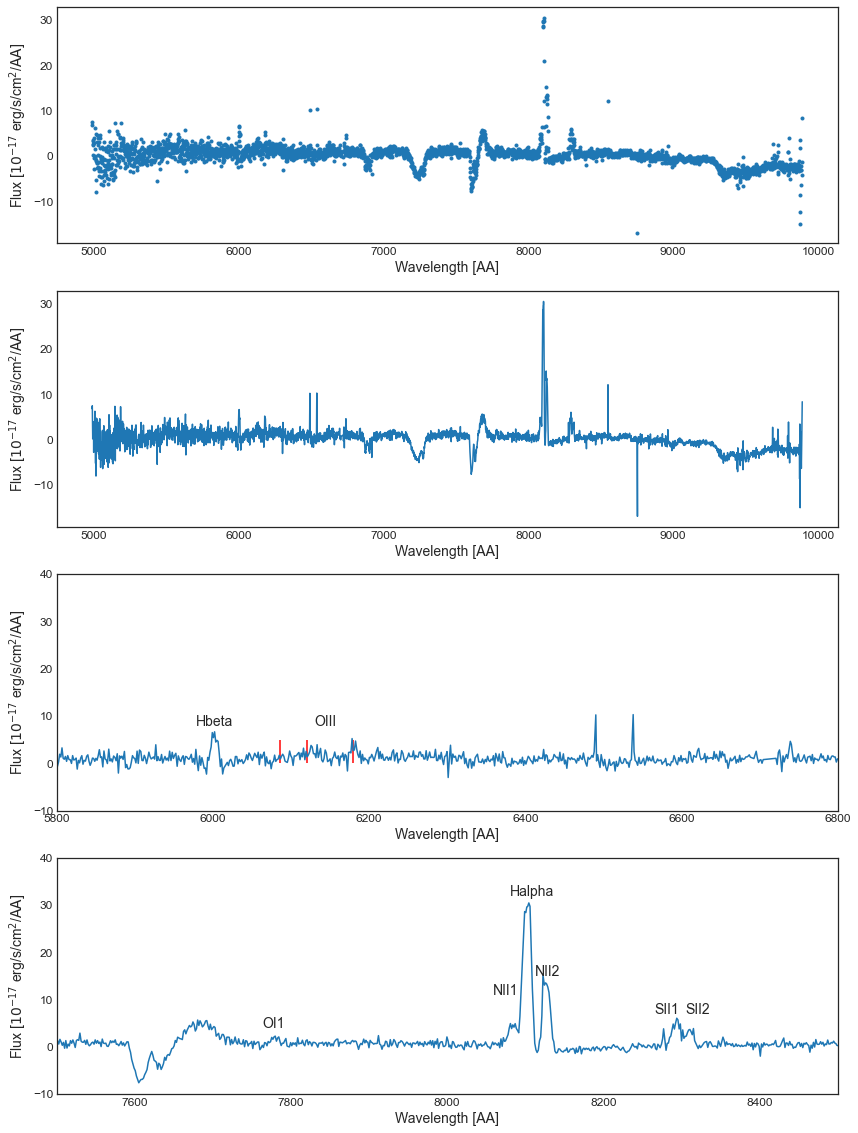

In [14]:
fig, ax = plt.subplots(nrows=4, figsize=(14,20))

ax[0].plot(wl_clean,flux_clean,'.')
ax[0].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/AA]')
ax[0].set_xlabel('Wavelength [AA]')

ax[1].plot(wl_clean,flux_clean)
ax[1].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/AA]')
ax[1].set_xlabel('Wavelength [AA]')

ax[2].plot(wl_clean,flux_clean)
ax[2].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/AA]')
ax[2].set_xlabel('Wavelength [AA]')
ax[2].set_xlim(5800,6800)
ax[2].set_ylim(-10,40)
ax[2].vlines(6086, 0, 5, color='red')
ax[2].vlines(6121, 0, 5, color='red')
ax[2].vlines(6180, 0, 5, color='red')
ax[2].annotate('Hbeta',(5978,8))
ax[2].annotate('OIII',(6130,8))

ax[3].plot(wl_clean,flux_clean)
ax[3].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/AA]')
ax[3].set_xlabel('Wavelength [AA]')
ax[3].set_xlim(7500,8500)
ax[3].set_ylim(-10,40)
ax[3].annotate('OI1',(7763,4))
ax[3].annotate('NII1',(8058,11))
ax[3].annotate('Halpha',(8080,32))
ax[3].annotate('NII2',(8112,15))
ax[3].annotate('SII1',(8265,7))
ax[3].annotate('SII2',(8305,7));

### Determining unique value of z and sigma

**Fit spectrum**

0.23422484175529323 7.337842951744747e-08


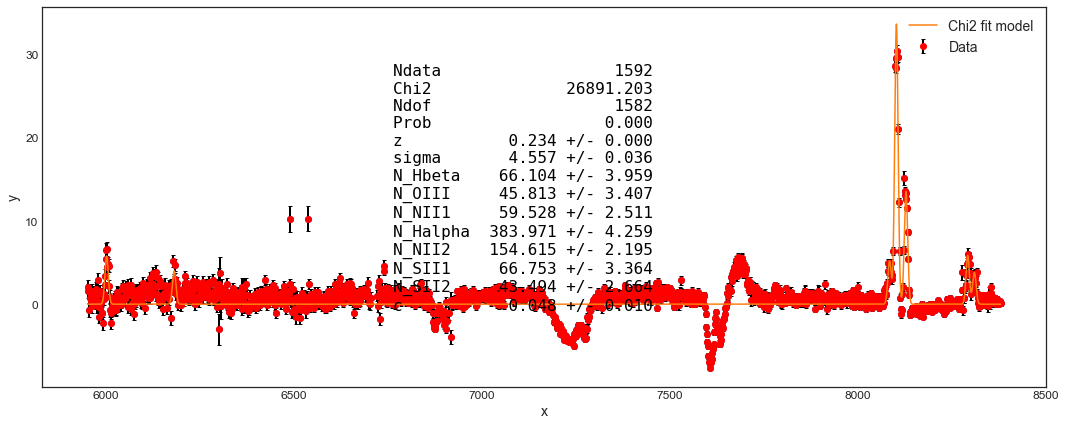

In [15]:
wl_cut, flux_cut, sig_cut = frb.cutpeak(wl_clean, flux_clean, sig_clean, 5950, 8380)

z, sigma, N_Hbeta, N_OIII, N_NII1, N_Halpha, N_NII2, N_SII1, N_SII2, c =  0.2340, 4, 50, 30, 45, 400, 216, 70, 30, 1

fig, ax = plt.subplots(figsize=(18,7))
_, _, _, par, par_err = frb.chisquarefit(wl_cut, flux_cut, sig_cut, frb.redshift, 
                    [z, sigma, N_Hbeta, N_OIII, N_NII1, N_Halpha, N_NII2, N_SII1, N_SII2, c], ax, plot=True, d_xy=[0.35, 0.85])

print(par[0], par_err[0])

**Plot spectrum nicely**

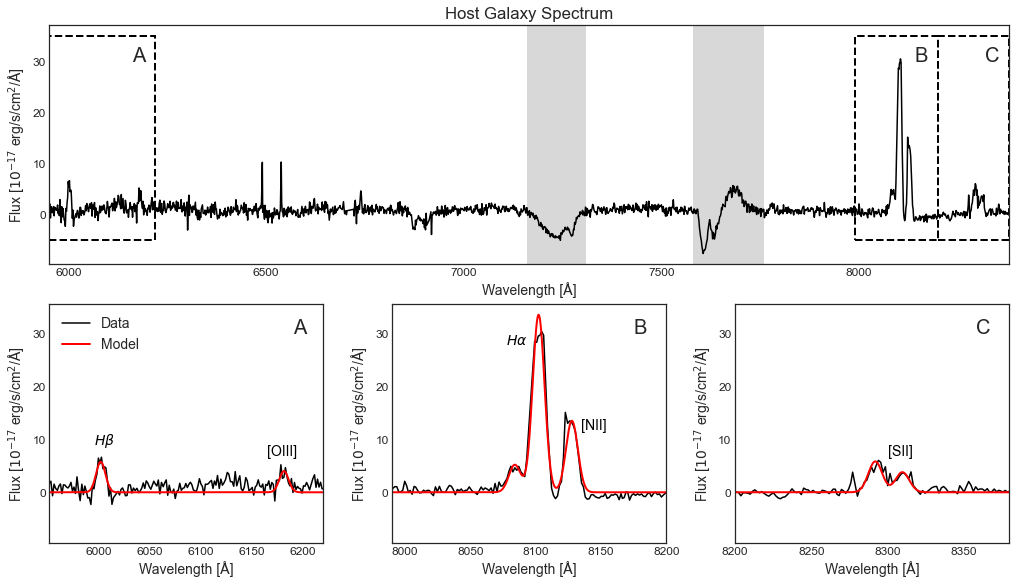

In [16]:
x = np.linspace(min(wl_cut), max(wl_cut), 100000)
y = frb.redshift(x, *par)

fig = plt.figure(figsize=(14, 8), constrained_layout=True)
spec = fig.add_gridspec(2, 3)

ax0 = fig.add_subplot(spec[0, :])
ax0.plot(wl_cut, flux_cut, color='black', lw=1.5)
#ax0.plot(x,y, color='black', lw=2)
ax0.set_xlabel('Wavelength [Å]', fontsize=14)
ax0.set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/Å]', fontsize=14)
#ax0.set_title('Spectrum of host galaxy', fontsize=16)
ax0.set_xlim(min(wl_cut), max(wl_cut))
ax0.add_patch(Rectangle((min(wl_cut),-5),6220-min(wl_cut),40,edgecolor='black',facecolor='none',ls='--',lw=2))
ax0.add_patch(Rectangle((7990,-5),8200-7990,40,edgecolor='black',facecolor='none',ls='--',lw=2))
ax0.add_patch(Rectangle((8200,-5),max(wl_cut)-8200,40,edgecolor='black',facecolor='none',ls='--',lw=2))
ax0.text(6220-60, 30, 'A', fontsize=20)
ax0.text(8200-60, 30, 'B', fontsize=20)
ax0.text(max(wl_cut)-60, 30, 'C', fontsize=20)
ax0.axvspan(7160, 7310, facecolor='grey', alpha=0.3)
ax0.axvspan(7580, 7760, facecolor='grey', alpha=0.3)
ax0.set_title('Host Galaxy Spectrum')

ax10 = fig.add_subplot(spec[1, 0])
ax10.plot(wl_cut, flux_cut, color='black', label='Data')
ax10.plot(x,y, color='red', lw=2, label='Model')
ax10.set_xlim(min(wl_cut), 6220)
ax10.annotate('$H \\beta $',(5995,9), color='black')
ax10.annotate('[OIII]',(6165,7), color='black')
ax10.set_xlabel('Wavelength [Å]', fontsize=14)
ax10.set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/Å]', fontsize=14)
ax10.legend(loc='upper left', fontsize=14)
ax10.text(6220-30, 30, 'A', fontsize=20)

ax11 = fig.add_subplot(spec[1, 1])
ax11.plot(wl_cut, flux_cut, color='black')
ax11.plot(x,y, color='red', lw=2)
ax11.set_xlim(7990, 8200) #210
ax11.annotate('$H \\alpha$',(8077,28), color='black')
ax11.annotate('[NII]',(8135,12), color='black')
ax11.set_xlabel('Wavelength [Å]', fontsize=14)
ax11.set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/Å]', fontsize=14)
ax11.text(8200-25, 30, 'B', fontsize=20)


ax12 = fig.add_subplot(spec[1, 2])
ax12.plot(wl_cut, flux_cut, color='black')
ax12.plot(x,y, color='red', lw=2)
ax12.set_xlim(8200, max(wl_cut))
ax12.annotate('[SII]',(8300,7), color='black')
ax12.set_xlabel('Wavelength [Å]', fontsize=14)
ax12.set_ylabel('Flux [$10^{-17}$ erg/s/cm$^2$/Å]', fontsize=14)
ax12.text(max(wl_cut)-22, 30, 'C', fontsize=20)


if save_plots:
        fig.savefig('spectrum2.pdf', dpi=300);

### Line flux

**LaTeX table with emission line fluxes**

In [17]:
names = np.array(['Hbeta', 'OIII', 'NII(1)', 'Halpha', 'NII(2)', 'SII(1)', 'SII(2)'])

print("\\begin{tabular}{cc}")
print("\t \\hline")
print("\t \\hline")
print("\t {0:15s} & {1:7s}\\\\".format( "Emission line", "Line flux [$10^{-17}$ erg/s/cm$^2$/Å]"))
print("\t \\hline")

for name, n, nsig  in zip(names, par[2:], par_err[2:]):
    print(f"\t {name:15s}  & \t {n:7.0f} $\pm$ {nsig:2.0f} \\\\")
    
print("\t \\hline")
print("\\end{tabular}")
print("")

\begin{tabular}{cc}
	 \hline
	 \hline
	 Emission line   & Line flux [$10^{-17}$ erg/s/cm$^2$/Å]\\
	 \hline
	 Hbeta            & 	      66 $\pm$  4 \\
	 OIII             & 	      46 $\pm$  3 \\
	 NII(1)           & 	      60 $\pm$  3 \\
	 Halpha           & 	     384 $\pm$  4 \\
	 NII(2)           & 	     155 $\pm$  2 \\
	 SII(1)           & 	      67 $\pm$  3 \\
	 SII(2)           & 	      43 $\pm$  3 \\
	 \hline
\end{tabular}



### Distance between FRB and HG

**Distance between center of FRB and HG**

In [18]:
frb_pos = SkyCoord('21h33m24.37s -54d44m51.9s', frame='icrs')      
hg_pos = SkyCoord('21h33m24.4648s -54d44m54.862s', frame='icrs')
sep = frb_pos.separation(hg_pos)

print('Distance between FRB and HG in arcsec =', sep.arcsecond,'\'\'')
print('Distance between FRB and HG in kpc =', frb.arc2kpc(sep.arcsecond, par[0]),'kpc')

Distance between FRB and HG in arcsec = 3.0736060926015365 ''
Distance between FRB and HG in kpc = 10.741288522935019 kpc


**3D visualization of the 2D uncertanties on the FRB position**

2D Gaussian uncertainties on the position of the FRB


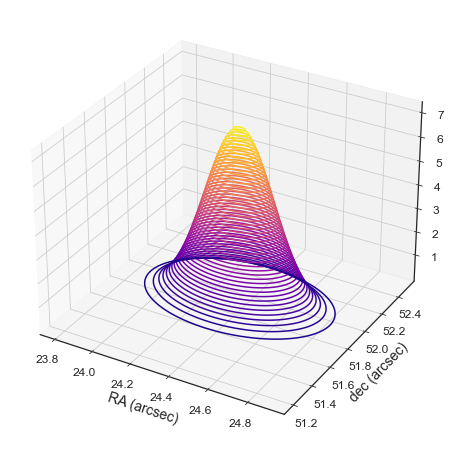

In [19]:
RA_mean, RA_sig, dec_mean, dec_sig = 24.37, a_sig, 51.90, b_sig

def gauss2d(x,y):
    return norm.pdf(x, RA_mean, RA_sig) * norm.pdf(y, dec_mean, dec_sig)

x = np.linspace(23.8,24.9,1000)
y = np.linspace(51.2,52.5,1000)

X, Y = np.meshgrid(x, y)
Z = gauss2d(X, Y)

print('2D Gaussian uncertainties on the position of the FRB')

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 70, cmap='plasma')
ax.set_xlabel('RA (arcsec)')
ax.set_ylabel('dec (arcsec)');

### Simulated 

**Drawing random positions from the Gaussian uncertainties** 

In [20]:
N_total = 100000

RA_gen = np.random.normal(RA_mean, RA_sig, N_total)
dec_gen = np.random.normal(dec_mean, dec_sig, N_total)

**Determining the distance between the random drawn positions**

In [21]:
simulated_distance = []

for i in range(N_total):
    simulated_distance.append(frb.sim_dist(RA_gen[i], dec_gen[i]))

**Sorting the distances and determining the 67% confidence interval**

In [22]:
simulated_distance_sorted = np.sort(simulated_distance)
low_lim = simulated_distance_sorted[int(N_total*0.16)]
high_lim = simulated_distance_sorted[int(N_total*0.84)]

**Plotting the distribution**

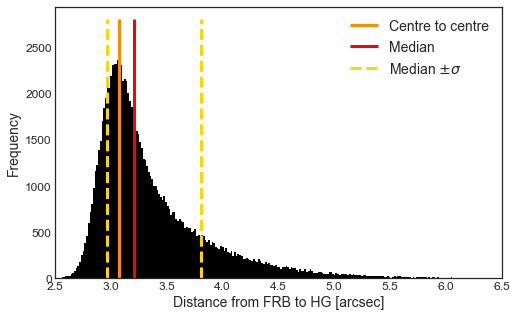

In [23]:
fig = plt.figure(figsize=(8,5))
plt.hist(simulated_distance, bins=300, color='black')
plt.xlim(2.5,6.5)
plt.xlabel('Distance from FRB to HG [arcsec]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.vlines(sep.arcsecond, 0,2800, color='darkorange', lw=3, label='Centre to centre') 
plt.vlines(np.median(simulated_distance), 0,2800, color='red', lw=3, label='Median')
plt.vlines(low_lim, 0,2800, color='gold', ls='dashed', lw=3, label='Median $\pm \sigma$')
plt.vlines(high_lim, 0,2800, color='gold', ls='dashed', lw=3)
plt.legend(fontsize=14);

if save_plots:
        fig.savefig('simulateddistance.pdf', dpi=300);

In [24]:
pos_sigma, neg_sigma = high_lim-np.median(simulated_distance), np.median(simulated_distance)-low_lim
print('Median:',np.median(simulated_distance), '+', pos_sigma, '-', neg_sigma)
print('67% cofidence interval ranges from', low_lim, 'to',high_lim)

Median: 3.207806582600289 + 0.6003769116405189 - 0.24593724742001077
67% cofidence interval ranges from 2.9618693351802783 to 3.808183494240808


In [25]:
print('Median:',frb.arc2kpc(np.median(simulated_distance), par[0]))
print('67% cofidence interval ranges from', frb.arc2kpc(low_lim, par[0]), 'to',frb.arc2kpc(high_lim,par[0]))

Median: 11.210277111442066
67% cofidence interval ranges from 10.35080362867094 to 13.308405966002322


### Probability 

**The effective radius r,** $r = max[\sqrt{R_0^2+4R_{half}^2}, 3\sigma_{R_0}]$

In [26]:
m = 18.41 #AB mag
Rh = 1.44 #arcsec
R0 = np.median(simulated_distance) #arcsec

R1 = np.sqrt(R0**2+4*Rh**2)
R2 = 3*pos_sigma
print('Effective radius max of:', R1, 'and', R2)

print('Probaility =', frb.prob(m,R0, Rh))

Effective radius max of: 4.3109654453931485 and 1.8011307349215566
Probaility = 0.00368322937779908


### DM(distance) plot

In [27]:
d_HG_Earth = 299792.458*z/67.4*1000 #kpc

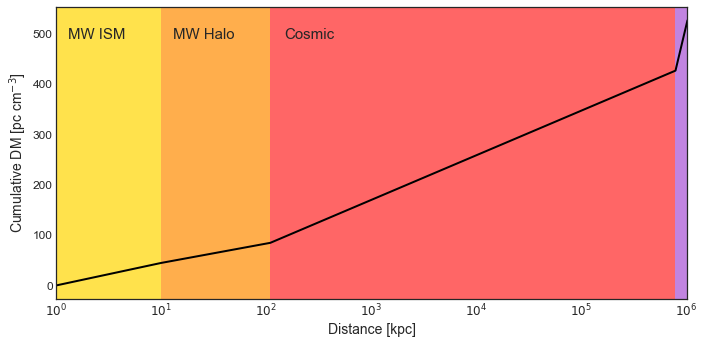

In [28]:
DM_MW_ISM = 44.7
DM_MW_halo = 40
DM_cosmic = 342.16272285251216
DM_host = 100

DM = np.array([0, DM_MW_ISM, DM_MW_ISM+DM_MW_halo, DM_MW_ISM+DM_MW_halo+DM_cosmic, DM_MW_ISM+DM_MW_halo+DM_cosmic+DM_host])
dist = np.array([1, 10, 110, 0.8e6, d_HG_Earth])


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dist, DM, color='black', lw=2)
ax.set_xscale('log')
#plt.fill_between([1,10], [0,500], [10,500], color='green')
ax.axvspan(0, 10, facecolor='gold', alpha=0.7)
ax.axvspan(10, 110, facecolor='darkorange', alpha=0.7)
ax.axvspan(110, 0.8e6, facecolor='red', alpha=0.6)
ax.axvspan(0.8e6, d_HG_Earth, facecolor='darkorchid', alpha=0.6)
ax.text(1.3, 490, 'MW ISM', fontsize=15)
ax.text(13, 490, 'MW Halo', fontsize=15)
ax.text(150, 490, 'Cosmic', fontsize=15)
#ax.text(1010000., 490, 'Host', fontsize=15)
ax.set_xlim(1,d_HG_Earth)
ax.set_xlabel('Distance [kpc]', fontsize=14)
ax.set_ylabel('Cumulative DM [pc cm$^{-3}$]', fontsize=14)
ax.set_xticks([1, 1e1, 1e2 , 1e3, 1e4 , 1e5, 1e6])
ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])

fig.tight_layout()

if save_plots:
        fig.savefig('DM_con.pdf', dpi=300);

### Half light radius

In [29]:
position = SkyCoord('21h33m24.4648s -54d44m54.862s', frame='icrs') 
wcs = WCS(hdr_hg)
size=(40,40) #ny, nx
cutout_hg = Cutout2D(data_hg, position, size, wcs=wcs)

**Determining angle and ratio between major and minor axis**

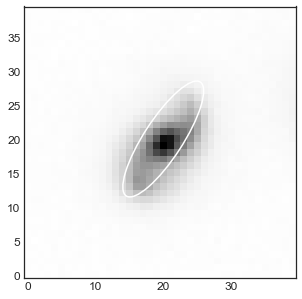

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(cutout_hg.data, origin='lower' )

x0, y0 = 20, 20
a, b =   10, 2.85
theta = Angle(57, 'deg')

e = mpatches.Ellipse((x0, y0), 2*a, 2*b,  theta.degree, edgecolor='white', facecolor='none', lw=1.5) 
ax.add_patch(e);

**Plotting the radiale profile**

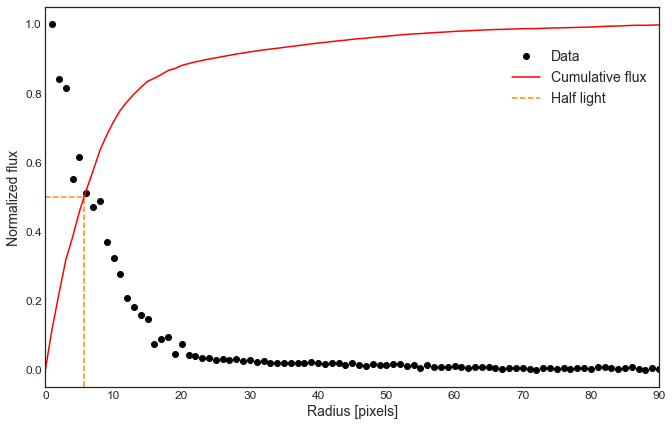

In [31]:
rad, cumlight, r = frb.radial_profile(cutout_hg.data, 57)
x = np.linspace(1,len(rad),len(rad))

cumlight2 = np.insert(cumlight, 0, 0)
x2 = np.insert(x, 0, 0)

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(x, rad/max(rad),'o', label='Data', color='black')
ax.plot(x2, cumlight2, color='red', ls='solid', label='Cumulative flux')
ax.hlines(0.5, 0, 5.7, color='darkorange', ls='dashed', label='Half light')
ax.vlines(5.7, -0.05, 0.505, color='darkorange', ls='dashed')

ax.set_ylabel('Normalized flux')
ax.set_xlabel('Radius [pixels]')
ax.set_xlim(0,90)
ax.set_ylim(-0.05,1.05)
ax.legend(bbox_to_anchor=(1,0.92), loc="upper right")
if save_plots:
        fig.savefig('halflightradius.pdf', dpi=300);

**Plotting the half light radius**

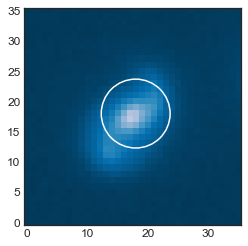

In [32]:
position = SkyCoord('21h33m24.4615s -54d44m54.855s', frame='icrs') 
wcs = WCS(hdr_hg)
size=(36,36) #ny, nx
cutout_hg = Cutout2D(data_hg, position, size, wcs=wcs)

x0, y0 = 18, 18
a, b =   5.7, 5.7
theta = Angle(PA, 'deg')

fig, ax = plt.subplots()
ax.imshow(cutout_hg.data, cmap='PuBu_r', vmin=cutout.data.min(), vmax=cutout.data.max(), origin='lower' )

e = mpatches.Ellipse((x0, y0), 2*a, 2*b,  theta.degree, edgecolor='white', facecolor='none', lw=1.5) 
ax.add_patch(e)

**Converting the half light radius from pixels to arcsec**

In [33]:
print(5.7*k_dec, 'dec') 
print(5.7*k_ra, 'RA')

1.4386582260000003 dec
1.4368916250000001 RA
